In [2]:
import numpy as np
import matplotlib.pyplot as plt
import graphs_helper
import time
from scipy.optimize import curve_fit
import scipy.optimize
import pylab

In [11]:
# get the carrington intersecting dictionaries
carrington303_dic, carrington199_dic = graphs_helper.get_carringdon_dictionaries_59to60()

date199,ygroups199,ysunspots199,ywolf199 = [],[],[],[]
date303,ygroups303,ysunspots303 = [],[],[]

for date in carrington199_dic:
    date199.append(date)
    ygroups199.append(carrington199_dic[date][0])
    ysunspots199.append(carrington199_dic[date][1])
    ywolf199.append(carrington199_dic[date][2])
    
    date303.append(date)
    ygroups303.append(carrington303_dic[date][0])
    ysunspots303.append(carrington303_dic[date][1])
    


mysql connection successfully established with GOOD_DATA_SILSO
data successfully retrieved
Closing MySQL connection...


fit parameter a : 1.2111109306343617
fit parameter b : 0.007682607312442986
covariance matrix:
[[ 7.95403183e-04 -2.86379144e-05]
 [-2.86379144e-05  1.31524617e-06]]



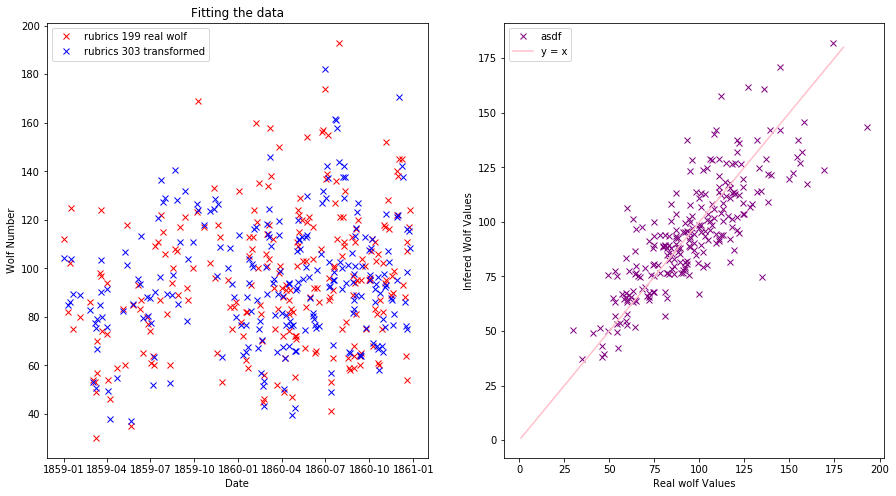

In [29]:
# 1) least squares fitting using non-modified groups

# r = a * (10 g + b * f) = 10 a * g + c * f
# Best fit model with 2 degrees of freedom
def r(gf,a,b):
    g=gf[0]
    f=gf[1]
    return a * (10 *g + b * f)

def r2(gf,a,b):
    g=gf[0]
    f=gf[1]
    output = []
    for i in range(len(g)):
        output.append(a*(10*g[i] + b * f[i]))
    return output

# takes lists of same length
def standard_deviation(model,data):
    var = 0
    for i in range(len(data)):
        

# fit
p0 = 1.4,0.15
popt, pcov = curve_fit(r,[ygroups303,ysunspots303],ywolf199,p0)

a = popt[0]
b = popt[1]
print("fit parameter a :",popt[0])
print("fit parameter b :",popt[1])
print("covariance matrix:"); print(pcov)
print()

wolf_adjusted_303 = r2([ygroups303,ysunspots303],a,b)

# plotting the fit would require 3 dimensions so I will just plot the residuals
plt.figure(figsize=(15,8))
plt.subplot(121)

plt.plot(date199,ywolf199,"rx",label="rubrics 199 real wolf")
plt.plot(date303,wolf_adjusted_303,"bx",label="rubrics 303 transformed")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Wolf Number")
plt.title("Fitting the data")

plt.subplot(122)

plt.plot(ywolf199,wolf_adjusted_303,"x",color="purple",label="asdf")
plt.plot(np.linspace(1,180,200),np.linspace(1,180,200),"-",color="pink",label="y = x")
plt.legend()
plt.xlabel("Real wolf Values")
plt.ylabel("Infered Wolf Values")

# calculate the standard deviation of my estimates from the real thing

plt.show()
